<a href="https://colab.research.google.com/github/simplething4057/Final-Team7/blob/patch-1/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
import pandas as pd

df = pd.read_csv('/content/dairy_dataset.csv')

In [239]:
df['Date']= pd.to_datetime(df['Date'])
df['Production Date'] = pd.to_datetime(df['Production Date'])
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])

# 유통기한 데이터
avg_Shelf_life = df.groupby('Product Name')['Shelf Life (days)'].mean().reset_index()
avg_Shelf_life

,Product Name,Shelf Life (days)
0,Butter,32.932715
1,Buttermilk,10.572414
2,Cheese,57.324190
3,Curd,6.025052
4,Ghee,105.741294
5,Ice Cream,25.458629
6,Lassi,14.847875
7,Milk,12.923077
8,Paneer,10.662132
9,Yogurt,25.517162


In [240]:
df

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,2022-02-16,2022-02-21,352,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,2022-03-22,2022-04-14,68,58.39,3970.52,Kerala,Retail,750,87.41,114.37
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,2020-01-04,2020-01-11,141,89.46,12613.86,Haryana,Retail,442,33.47,153.66
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,2022-10-02,2022-10-09,2,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84


In [241]:
# 생산지역 맵핑
regions = sorted(df['Location'].unique())
region_mapping = {region: i + 1 for i, region in enumerate(regions)}
df['Location_Mapped'] = df['Location'].map(region_mapping)

# 고객지역 맵핑
df['Customer_Location_Mapped'] = df['Customer Location'].map(region_mapping)

In [242]:
import numpy as np

col = ["Production Date", "Shelf Life (days)", "Expiration Date", "Date", "Location_Mapped", "Product ID", "Quantity (liters/kg)", "Quantity Sold (liters/kg)", "Quantity in Stock (liters/kg)", "Minimum Stock Threshold (liters/kg)", "Reorder Quantity (liters/kg)"]
df_stock = df.loc[:, col].sort_values(by="Date").reset_index()

df_stock['Sales_Period_Days'] = (df_stock['Date'] - df_stock['Production Date']).dt.days
df_stock["Avg_Daily_Sales"] = df_stock["Quantity Sold (liters/kg)"] / (df_stock["Date"] - df_stock["Production Date"]).dt.days
df_stock['Remaining_Shelf_Life'] = (df_stock['Expiration Date'] - df_stock['Date']).dt.days
df_stock['Expected_Waste_Qty'] = np.where(
    df_stock['Remaining_Shelf_Life'] <= 0,
    df_stock['Quantity in Stock (liters/kg)'],
    (df_stock['Quantity in Stock (liters/kg)'] - (df_stock['Avg_Daily_Sales'] * df_stock['Remaining_Shelf_Life'])).clip(lower=0)
)
df_stock['Expected_Waste_Qty'].fillna(df_stock['Quantity in Stock (liters/kg)'], inplace=True)
df_stock['Days_to_Stockout'] = df_stock['Quantity in Stock (liters/kg)'] / df_stock['Avg_Daily_Sales']
df_stock['Risk_Flag'] = df_stock['Days_to_Stockout'] > df_stock['Remaining_Shelf_Life']

/tmp/ipython-input-1683562088.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_stock['Expected_Waste_Qty'].fillna(df_stock['Quantity in Stock (liters/kg)'], inplace=True)


In [243]:
df

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Location_Mapped,Customer_Location_Mapped
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03,13,9
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10,14,8
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83,12,9
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68,13,11
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,352,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53,3,14
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,68,58.39,3970.52,Kerala,Retail,750,87.41,114.37,6,8
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,141,89.46,12613.86,Haryana,Retail,442,33.47,153.66,2,5
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,2,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84,10,6


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Location                             4325 non-null   object        
 1   Total Land Area (acres)              4325 non-null   float64       
 2   Number of Cows                       4325 non-null   int64         
 3   Farm Size                            4325 non-null   object        
 4   Date                                 4325 non-null   datetime64[ns]
 5   Product ID                           4325 non-null   int64         
 6   Product Name                         4325 non-null   object        
 7   Brand                                4325 non-null   object        
 8   Quantity (liters/kg)                 4325 non-null   float64       
 9   Price per Unit                       4325 non-null   float64       
 10  Total Value 

In [245]:
df.describe()

,Total Land Area (acres),Number of Cows,Date,Product ID,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Location_Mapped,Customer_Location_Mapped
count,4325.000000,4325.000000,4325,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325,4325,4325.000000,4325.00000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000
mean,503.483073,54.963699,2020-12-15 22:59:04.231213824,5.509595,500.652657,54.785938,27357.845411,29.127630,2020-11-15 08:53:22.959537664,2020-12-14 11:57:10.196531968,248.095029,54.77914,13580.265401,252.068671,55.826143,109.107820,7.300347,7.403237
min,10.170000,10.000000,2019-01-01 00:00:00,1.000000,1.170000,10.030000,42.516500,1.000000,2018-11-02 00:00:00,2018-11-14 00:00:00,1.000000,5.21000,12.540000,0.000000,10.020000,20.020000,1.000000,1.000000
25%,252.950000,32.000000,2019-12-20 00:00:00,3.000000,254.170000,32.460000,9946.814500,10.000000,2019-11-23 00:00:00,2019-12-20 00:00:00,69.000000,32.64000,2916.650000,66.000000,32.910000,64.280000,3.000000,3.000000
50%,509.170000,55.000000,2020-12-02 00:00:00,6.000000,497.550000,54.400000,21869.652900,22.000000,2020-10-29 00:00:00,2020-11-29 00:00:00,189.000000,54.14000,8394.540000,191.000000,56.460000,108.340000,7.000000,7.000000
75%,751.250000,77.000000,2021-12-15 00:00:00,8.000000,749.780000,77.460000,40954.441000,30.000000,2021-11-16 00:00:00,2021-12-13 00:00:00,374.000000,77.46000,19504.550000,387.000000,79.010000,153.390000,11.000000,11.000000
max,999.530000,100.000000,2022-12-28 00:00:00,10.000000,999.930000,99.990000,99036.369600,150.000000,2022-12-22 00:00:00,2023-05-17 00:00:00,960.000000,104.51000,89108.900000,976.000000,99.990000,199.950000,15.000000,15.000000
std,285.935061,26.111487,NaN,2.842979,288.975915,26.002815,21621.051594,30.272114,NaN,NaN,217.024182,26.19279,14617.009122,223.620870,26.301450,51.501035,4.423124,4.466256


In [246]:
df.describe(include='object')

,Location,Farm Size,Product Name,Brand,Storage Condition,Customer Location,Sales Channel
count,4325,4325,4325,4325,4325,4325,4325
unique,15,3,10,11,5,15,3
top,Delhi,Large,Curd,Amul,Refrigerated,Delhi,Retail
freq,525,1462,479,1053,2459,499,1478


In [247]:
df['Sales Period Date'] = df['Date'] - df['Production Date']
df['Avg Daily Sales'] = df['Quantity Sold (liters/kg)'] / df['Sales Period Date'].dt.days
df['Remaining Shelf Life'] = df['Expiration Date'] - df['Date']

In [248]:
df[['Production Date', 'Shelf Life (days)', 'Expiration Date','Date', 'Product ID', 'Quantity (liters/kg)', 'Quantity Sold (liters/kg)', 'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)', 'Reorder Quantity (liters/kg)', 'Sales Period Date','Avg Daily Sales', 'Remaining Shelf Life']]

,Production Date,Shelf Life (days),Expiration Date,Date,Product ID,Quantity (liters/kg),Quantity Sold (liters/kg),Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Sales Period Date,Avg Daily Sales,Remaining Shelf Life
0,2021-12-27,25,2022-01-21,2022-02-17,5,222.40,7,215,19.55,64.03,52 days,0.134615,-27 days
1,2021-10-03,22,2021-10-25,2021-12-01,1,687.48,558,129,43.17,181.10,59 days,9.457627,-37 days
2,2022-01-14,30,2022-02-13,2022-02-28,4,503.48,256,247,15.10,140.83,45 days,5.688889,-15 days
3,2019-05-15,72,2019-07-26,2019-06-09,3,823.36,601,222,74.50,57.68,25 days,24.040000,47 days
4,2020-10-17,11,2020-10-28,2020-12-14,8,147.77,145,2,76.02,33.40,58 days,2.500000,-47 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,2022-02-16,5,2022-02-21,2022-02-24,6,554.90,352,202,98.07,33.53,8 days,44.000000,-3 days
4321,2022-03-22,23,2022-04-14,2022-05-14,4,818.33,68,750,87.41,114.37,53 days,1.283019,-30 days
4322,2020-01-04,7,2020-01-11,2020-01-05,6,583.56,141,442,33.47,153.66,1 days,141.000000,6 days
4323,2022-10-02,7,2022-10-09,2022-10-25,6,3.10,2,1,58.25,160.84,23 days,0.086957,-16 days


In [249]:
df.iloc[[471, 3962]]

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Location_Mapped,Customer_Location_Mapped,Sales Period Date,Avg Daily Sales,Remaining Shelf Life
471,Chandigarh,752.19,71,Small,2020-07-14,10,Ghee,Sudha,783.28,21.14,...,Telangana,Retail,248,79.80,152.71,2,13,7 days,76.428571,91 days
3962,Chandigarh,31.73,64,Medium,2020-07-13,10,Ghee,Sudha,93.19,89.34,...,Tamil Nadu,Retail,18,35.67,55.89,2,12,6 days,12.500000,109 days


In [250]:
df['Location'].unique()

array(['Telangana', 'Uttar Pradesh', 'Tamil Nadu', 'Maharashtra',
       'Karnataka', 'Bihar', 'West Bengal', 'Madhya Pradesh',
       'Chandigarh', 'Delhi', 'Gujarat', 'Kerala', 'Jharkhand',
       'Rajasthan', 'Haryana'], dtype=object)

In [251]:
df['Customer Location'].unique()

array(['Madhya Pradesh', 'Kerala', 'Rajasthan', 'Jharkhand', 'Gujarat',
       'Karnataka', 'Haryana', 'Tamil Nadu', 'West Bengal', 'Telangana',
       'Chandigarh', 'Maharashtra', 'Delhi', 'Bihar', 'Uttar Pradesh'],
      dtype=object)

In [252]:
Chandigarh_small = df.loc[(df['Location'] == 'Chandigarh') & (df['Farm Size'] == 'Small')]

In [253]:
Chandigarh_small.sort_values(by='Production Date', ascending=True)

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Location_Mapped,Customer_Location_Mapped,Sales Period Date,Avg Daily Sales,Remaining Shelf Life
3283,Chandigarh,255.69,57,Small,2019-01-18,7,Lassi,Amul,34.61,42.72,...,Maharashtra,Retail,24,75.41,39.11,2,10,53 days,0.188679,-39 days
1586,Chandigarh,364.38,60,Small,2019-01-27,7,Lassi,Mother Dairy,17.84,22.26,...,Chandigarh,Online,9,40.42,54.18,2,2,47 days,0.170213,-35 days
3572,Chandigarh,395.78,50,Small,2019-01-15,2,Butter,Warana,929.13,52.15,...,Karnataka,Online,329,99.53,65.43,2,7,28 days,21.428571,12 days
1101,Chandigarh,767.61,95,Small,2019-02-12,3,Cheese,Britannia Industries,572.36,26.01,...,Kerala,Retail,139,66.08,148.41,2,8,54 days,8.018519,-8 days
4300,Chandigarh,246.36,76,Small,2019-01-26,9,Paneer,Mother Dairy,492.42,23.88,...,West Bengal,Wholesale,116,68.53,133.16,2,15,36 days,10.444444,-25 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Chandigarh,67.36,49,Small,2022-11-20,8,Buttermilk,Amul,362.51,95.74,...,Jharkhand,Online,69,21.61,149.61,2,6,49 days,5.979592,-42 days
545,Chandigarh,162.24,29,Small,2022-10-04,7,Lassi,Amul,722.73,40.72,...,Rajasthan,Retail,530,53.12,38.47,2,11,2 days,96.000000,13 days
2594,Chandigarh,27.78,39,Small,2022-12-04,7,Lassi,Amul,863.09,15.73,...,Jharkhand,Wholesale,512,88.61,191.02,2,6,35 days,10.028571,-19 days
1680,Chandigarh,784.89,66,Small,2022-11-27,5,Ice Cream,Mother Dairy,365.30,12.80,...,Gujarat,Online,195,65.91,157.56,2,4,2 days,85.000000,23 days


In [254]:
df.drop("Farm Size", axis=1, inplace=True)

In [255]:
df

,Location,Total Land Area (acres),Number of Cows,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,Total Value,...,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Location_Mapped,Customer_Location_Mapped,Sales Period Date,Avg Daily Sales,Remaining Shelf Life
0,Telangana,310.84,96,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,19064.1280,...,Madhya Pradesh,Wholesale,215,19.55,64.03,13,9,52 days,0.134615,-27 days
1,Uttar Pradesh,19.19,44,2021-12-01,1,Milk,Amul,687.48,42.61,29293.5228,...,Kerala,Wholesale,129,43.17,181.10,14,8,59 days,9.457627,-37 days
2,Tamil Nadu,581.69,24,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,18377.0200,...,Madhya Pradesh,Online,247,15.10,140.83,12,9,45 days,5.688889,-15 days
3,Telangana,908.00,89,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,21835.5072,...,Rajasthan,Online,222,74.50,57.68,13,11,25 days,24.040000,47 days
4,Maharashtra,861.95,21,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,12390.5145,...,Jharkhand,Retail,2,76.02,33.40,10,6,58 days,2.500000,-47 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,49080.9050,...,Uttar Pradesh,Online,202,98.07,33.53,3,14,8 days,44.000000,-3 days
4321,Jharkhand,385.91,29,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,45294.5655,...,Kerala,Retail,750,87.41,114.37,6,8,53 days,1.283019,-30 days
4322,Chandigarh,311.54,65,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,54043.4916,...,Haryana,Retail,442,33.47,153.66,2,5,1 days,141.000000,6 days
4323,Maharashtra,890.55,90,2022-10-25,6,Curd,Raj,3.10,15.30,47.4300,...,Jharkhand,Wholesale,1,58.25,160.84,10,6,23 days,0.086957,-16 days


In [256]:
df['discount ratio'] = ((df['Price per Unit']-df['Price per Unit (sold)'])/df['Price per Unit']*100).round(2)

In [290]:
df['Date2'] = df['Production Date']- df['Date']

In [307]:
df_DR = df[['Production Date', 'Date', 'Date2', 'Quantity (liters/kg)', 'Customer Location', 'Product Name', 'Storage Condition', 'Quantity Sold (liters/kg)', 'Price per Unit','Price per Unit (sold)', 'discount ratio', 'Expected_Waste_Qty']]

In [308]:
df_dr = df_DR.sort_values(by='Date', ascending=True)

In [310]:
df_dr.loc[(df['Product Name'] == 'Milk') & (df['Storage Condition'] == 'Polythene Packet')]

,Production Date,Date,Date2,Quantity (liters/kg),Customer Location,Product Name,Storage Condition,Quantity Sold (liters/kg),Price per Unit,Price per Unit (sold),discount ratio,Expected_Waste_Qty
722,2018-11-18,2019-01-06,-49 days,502.03,Haryana,Milk,Polythene Packet,41,18.86,20.10,-6.57,461.0
609,2019-01-07,2019-01-18,-11 days,761.45,Gujarat,Milk,Polythene Packet,9,49.28,47.47,3.67,752.0
4324,2019-01-06,2019-01-20,-14 days,820.50,Madhya Pradesh,Milk,Polythene Packet,417,49.31,44.55,9.65,403.0
4068,2018-12-08,2019-01-21,-44 days,318.29,Gujarat,Milk,Polythene Packet,292,49.68,51.65,-3.97,26.0
1316,2018-12-04,2019-01-24,-51 days,64.26,Karnataka,Milk,Polythene Packet,30,70.75,70.83,-0.11,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3178,2022-10-09,2022-12-08,-60 days,16.79,Jharkhand,Milk,Polythene Packet,14,11.34,14.64,-29.10,2.0
1988,2022-12-08,2022-12-10,-2 days,180.38,Telangana,Milk,Polythene Packet,78,85.62,89.34,-4.34,102.0
827,2022-10-31,2022-12-23,-53 days,306.48,West Bengal,Milk,Polythene Packet,29,97.59,93.23,4.47,277.0
654,2022-12-10,2022-12-24,-14 days,446.48,Maharashtra,Milk,Polythene Packet,359,60.27,63.49,-5.34,87.0


In [293]:
df_dr.loc[(df['Product Name'] == 'Milk') & (df['Customer Location'] == 'Chandigarh')]

,Production Date,Date,Date2,Quantity (liters/kg),Customer Location,Product Name,Price per Unit,Price per Unit (sold),discount ratio
873,2018-12-07,2019-01-11,-35 days,842.01,Chandigarh,Milk,48.67,47.24,2.94
720,2019-02-17,2019-03-08,-19 days,967.46,Chandigarh,Milk,39.35,41.34,-5.06
2571,2019-01-31,2019-03-19,-47 days,21.76,Chandigarh,Milk,11.79,12.78,-8.40
262,2019-04-20,2019-05-15,-25 days,618.02,Chandigarh,Milk,63.42,59.26,6.56
2798,2019-07-10,2019-07-25,-15 days,186.73,Chandigarh,Milk,76.45,73.00,4.51
3145,2019-08-29,2019-10-13,-45 days,197.40,Chandigarh,Milk,60.07,60.41,-0.57
1880,2019-09-17,2019-11-15,-59 days,204.49,Chandigarh,Milk,54.92,50.17,8.65
2291,2019-10-20,2019-11-16,-27 days,760.19,Chandigarh,Milk,82.01,80.72,1.57
2547,2019-11-12,2019-12-07,-25 days,860.94,Chandigarh,Milk,86.13,83.57,2.97
2654,2019-12-29,2020-02-11,-44 days,100.88,Chandigarh,Milk,15.90,16.69,-4.97


In [298]:
df['Customer Location'].unique()

array(['Madhya Pradesh', 'Kerala', 'Rajasthan', 'Jharkhand', 'Gujarat',
       'Karnataka', 'Haryana', 'Tamil Nadu', 'West Bengal', 'Telangana',
       'Chandigarh', 'Maharashtra', 'Delhi', 'Bihar', 'Uttar Pradesh'],
      dtype=object)

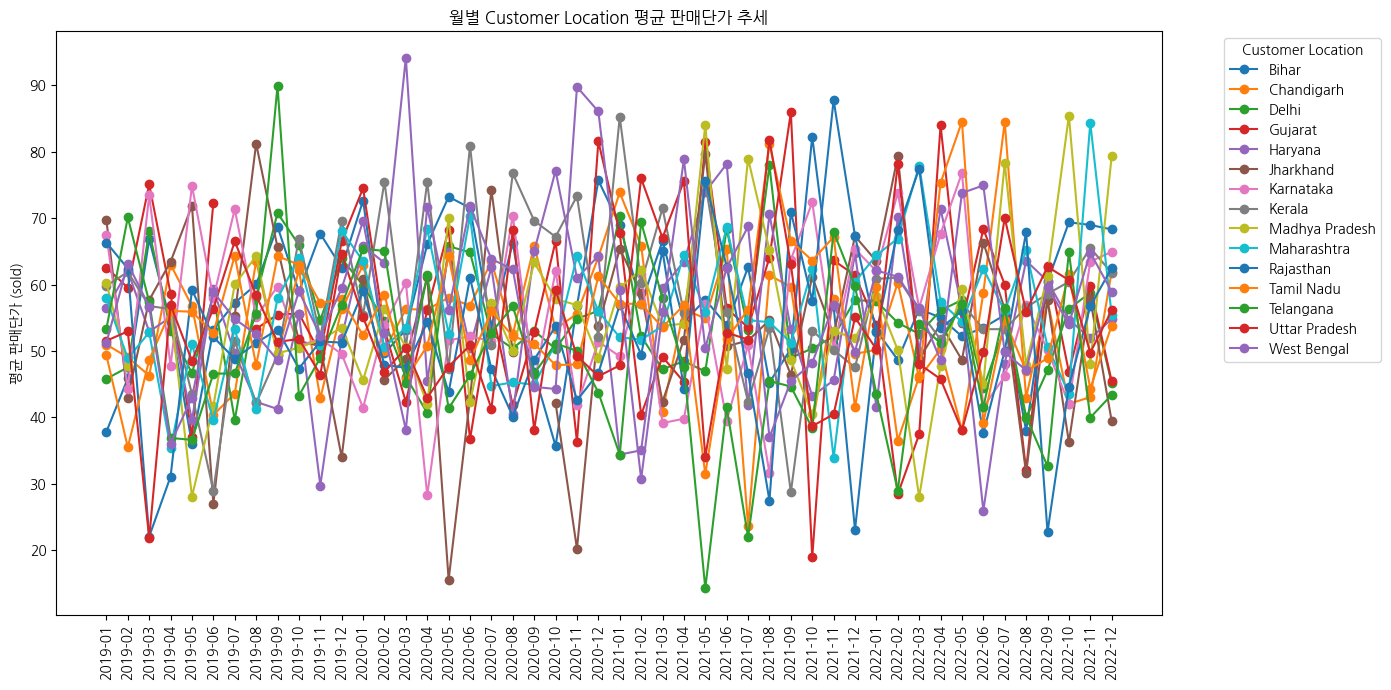

In [296]:
import matplotlib.pyplot as plt

# 월별 집계
df["YearMonth"] = df["Date"].dt.to_period("M").astype(str)

monthly_price = (
    df.groupby(["YearMonth", "Customer Location"])["Price per Unit (sold)"]
      .mean()
      .reset_index()
)

# Pivot for plotting
pivot_monthly = monthly_price.pivot(index="YearMonth", columns="Customer Location", values="Price per Unit (sold)")

# Plot
plt.figure(figsize=(14,7))
for col in pivot_monthly.columns:
    plt.plot(pivot_monthly.index, pivot_monthly[col], marker="o", label=col)

plt.xticks(rotation=90)
plt.ylabel("평균 판매단가 (sold)")
plt.title("월별 Customer Location 평균 판매단가 추세")
plt.legend(title="Customer Location", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


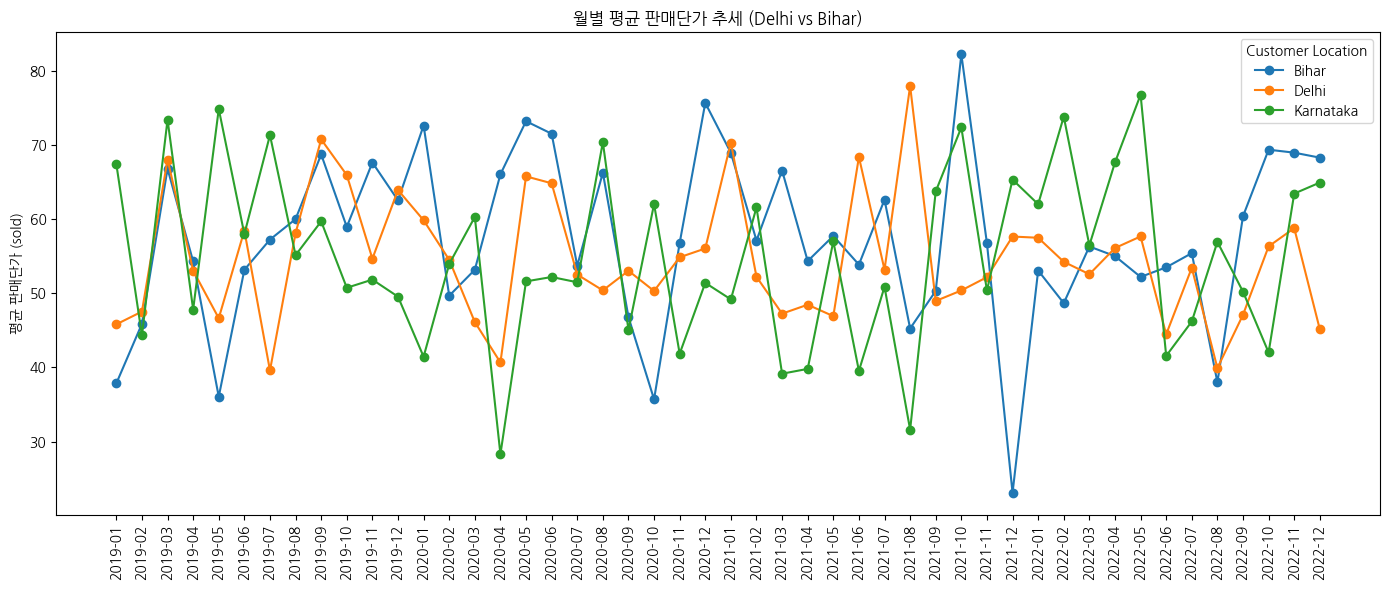

In [300]:
# Delhi, Bihar만 필터링
subset_locs = ["Delhi", "Bihar", "Karnataka"]
subset_df = monthly_price[monthly_price["Customer Location"].isin(subset_locs)]

# Pivot for plotting
pivot_subset = subset_df.pivot(index="YearMonth", columns="Customer Location", values="Price per Unit (sold)")

# Plot
plt.figure(figsize=(14,6))
for col in pivot_subset.columns:
    plt.plot(pivot_subset.index, pivot_subset[col], marker="o", label=col)

plt.xticks(rotation=90)
plt.ylabel("평균 판매단가 (sold)")
plt.title("월별 평균 판매단가 추세 (Delhi vs Bihar)")
plt.legend(title="Customer Location")
plt.tight_layout()
plt.show()


In [301]:
# 시계열 전처리
df["Date"] = pd.to_datetime(df["Date"])
df["Production Date"] = pd.to_datetime(df["Production Date"])
df["Expiration Date"] = pd.to_datetime(df["Expiration Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# 생산지역 맵핑
regions = sorted(df['Location'].unique())
region_mapping = {region: i + 1 for i, region in enumerate(regions)}
df['Location_Mapped'] = df['Location'].map(region_mapping)

# 고객지역 맵핑
df['Customer_Location_Mapped'] = df['Customer Location'].map(region_mapping)

# -----------------------------
# df에도 신규 컬럼 추가
# -----------------------------

# 판매기간 일수
df['Sales_Period_Days'] = (df['Date'] - df['Production Date']).dt.days

# 평균 일일 매출
df["Avg_Daily_Sales"] = df["Quantity Sold (liters/kg)"] / df['Sales_Period_Days']

# 남은 유통기한
df['Remaining_Shelf_Life'] = (df['Expiration Date'] - df['Date']).dt.days

# 예상 폐기물 수량
df['Expected_Waste_Qty'] = np.where(
    df['Remaining_Shelf_Life'] <= 0,
    df['Quantity in Stock (liters/kg)'],
    (df['Quantity in Stock (liters/kg)'] - (df['Avg_Daily_Sales'] * df['Remaining_Shelf_Life'])).clip(lower=0)
)

df['Expected_Waste_Qty'].fillna(df['Quantity in Stock (liters/kg)'], inplace=True)

# 재고 소진일까지 걸리는 일수
df['Days_to_Stockout'] = df['Quantity in Stock (liters/kg)'] / df['Avg_Daily_Sales']

# 위험 플래그 (기한 내 판매되지 않는 지표)
df['Risk_Flag'] = df['Days_to_Stockout'] > df['Remaining_Shelf_Life']

/tmp/ipython-input-264567219.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Expected_Waste_Qty'].fillna(df['Quantity in Stock (liters/kg)'], inplace=True)


In [303]:
# 재고손실율 계산 = 예상 폐기물 수량 / 재고 수량
df['Waste_Rate'] = df['Expected_Waste_Qty'] / df['Quantity in Stock (liters/kg)']

# 전체 평균 폐기율
overall_waste_rate = df['Waste_Rate'].mean()

# 제품별 평균 폐기율
product_waste_rate = df.groupby("Product Name")['Waste_Rate'].mean().reset_index()

# 지역별 평균 폐기율
location_waste_rate = df.groupby("Location")['Waste_Rate'].mean().reset_index()

# 보관조건별 평균 폐기율
storage_waste_rate = df.groupby("Storage Condition")['Waste_Rate'].mean().reset_index()

print(" 전체 평균 폐기율:", overall_waste_rate)
print("\n 제품별 평균 폐기율:")
print(product_waste_rate)
print("\n 지역별 평균 폐기율:")
print(location_waste_rate)
print("\n 보관조건별 평균 폐기율:")
print(storage_waste_rate)

 전체 평균 폐기율: 0.7277042895255375

 제품별 평균 폐기율:
  Product Name  Waste_Rate
0       Butter    0.676583
1   Buttermilk    0.895982
2       Cheese    0.401839
3         Curd    0.944465
4         Ghee    0.191038
5    Ice Cream    0.718500
6        Lassi    0.854801
7         Milk    0.880776
8       Paneer    0.907097
9       Yogurt    0.715858

 지역별 평균 폐기율:
          Location  Waste_Rate
0            Bihar    0.729089
1       Chandigarh    0.735220
2            Delhi    0.725805
3          Gujarat    0.686358
4          Haryana    0.779120
5        Jharkhand    0.760264
6        Karnataka    0.722458
7           Kerala    0.669391
8   Madhya Pradesh    0.754107
9      Maharashtra    0.742361
10       Rajasthan    0.723842
11      Tamil Nadu    0.667692
12       Telangana    0.736124
13   Uttar Pradesh    0.732518
14     West Bengal    0.740046

 보관조건별 평균 폐기율:
  Storage Condition  Waste_Rate
0           Ambient    0.191038
1            Frozen    0.647929
2  Polythene Packet    1.000000
3   